In [3]:
#폴더 새성 및 연
! mkdir -p ~/work/human_segmentation/models
! mkdir -p ~/work/human_segmentation/images
! ln -s ~/data/* ~/work/human_segmentation/images

ln: failed to create symbolic link '/home/jovyan/work/human_segmentation/images/my_image.png': File exists


In [1]:
#패키지 설
! pip install opencv-python pixellib # 다시 시작이 요구될 수 있습니다.

In [2]:
#패키지 불러오

# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# torch: PyTorch. 딥러닝 및 텐서 연산을 위한 라이브러리. 인공지능 모델을 만들거나 불러와 추론하는 도구
# torchvision: 이미지 변환 및 전처리를 위한 torchvision의 transform 모듈
# deeplabv3_resnet101: 사전 학습된 DeepLabV3 모델. 이미지를 분류하도록 학습된 모델
# matplotlib: 파이썬 프로그래밍 언어 및 수학적 확장 NumPy 라이브러리를 활용한 플로팅 라이브러리로, 데이터 시각화 도구

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

print('슝=3')

슝=3


In [3]:
# 기본 제공 이미지입니다. 여러분만의 이미지로 바꿔보세요!
! wget https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
! mv E-14-3.max-800x600_KwXP73b.png ~/work/human_segmentation/images/my_image.png

--2025-07-29 03:54:44--  https://d3s0tskafalll9.cloudfront.net/media/images/E-14-3.max-800x600_KwXP73b.png
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 54.192.18.125, 54.192.18.91, 54.192.18.116, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|54.192.18.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662087 (647K) [image/png]
Saving to: ‘E-14-3.max-800x600_KwXP73b.png’

E-14-3.max-800x600_ 100%[===================>] 646.57K  2.36MB/s    in 0.3s    

2025-07-29 03:54:45 (2.36 MB/s) - ‘E-14-3.max-800x600_KwXP73b.png’ saved [662087/662087]



이미지 크기: (797, 644, 3)


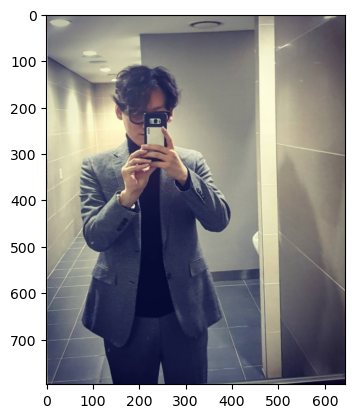

In [4]:
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장

home_dir = os.getenv('HOME')
img_path = os.path.join(home_dir, "work/human_segmentation/images/sg_4.png")
img_orig = cv2.imread(img_path)

print(f"이미지 크기: {img_orig.shape}")

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
# DeepLabV3_ResNet101 모델과 가중치 정의 임포트
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
model = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).eval()

In [6]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기 (고정)
    T.ToTensor(),
])

In [7]:
input_tensor = transform(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)).unsqueeze(0)

In [8]:
%%time
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 원본 크기로 Resize
output_predictions_resized = cv2.resize(
    output_predictions, 
    (img_orig.shape[1], img_orig.shape[0]), 
    interpolation=cv2.INTER_NEAREST
)

CPU times: user 9.18 s, sys: 149 ms, total: 9.33 s
Wall time: 9.45 s


In [9]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

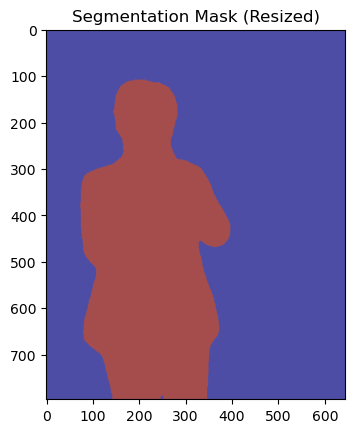

In [10]:
plt.imshow(output_predictions_resized, cmap="jet", alpha=0.7)
plt.title("Segmentation Mask (Resized)")
plt.show()

In [11]:
unique_classes = np.unique(output_predictions_resized)
unique_classes

array([ 0, 15], dtype=uint8)

In [12]:
for class_id in unique_classes:
    print(LABEL_NAMES[class_id])

background
person


In [13]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생성 코드 결과물이예요!

#컬러맵 만들기
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [14]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

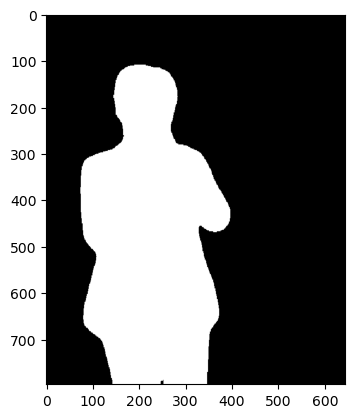

In [15]:
# output의 픽셀 별로 예측된 class가 사람이라면 1(True), 다르다면 0(False)이 됩니다
# 1과 0에 각각 255를 곱하였으므로 사람으로 예측된 픽셀은 255, 그렇지 않은 픽셀은 0
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = (output_predictions_resized == 15)  # 클래스 ID 15 (사람)
img_mask = seg_map.astype(np.uint8) * 255  # 255 값으로 변환
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

plt.imshow(img_mask, cmap='gray')  # 흑백으로 표시
plt.show()

새로운 배경 이미지 크기: (797, 644, 3)


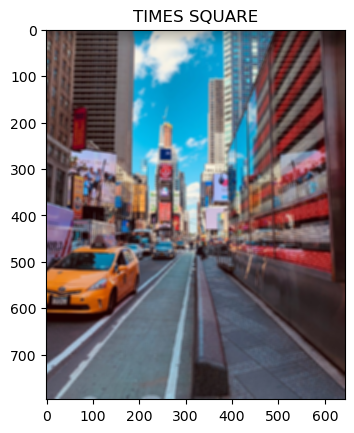

In [19]:
# --- 여기에 새로운 배경 이미지 로드 코드 추가 ---


new_bg_path = os.path.join(home_dir, "work/human_segmentation/images/sg_6.png")
img_new_bg = cv2.imread(new_bg_path)

img_new_bg = cv2.blur(img_new_bg, (7, 7))

# 새로운 배경 이미지도 RGB로 변환하여 시각화 (확인용)
if img_new_bg is None:
    print(f"오류: 배경 이미지 파일을 읽을 수 없습니다. 경로를 확인하세요: {new_bg_path}")
else:
    print(f"새로운 배경 이미지 크기: {img_new_bg.shape}")
    plt.imshow(cv2.cvtColor(img_new_bg, cv2.COLOR_BGR2RGB))
    plt.title("TIMES SQUARE")
    plt.show()

# --- 여기까지 추가 ---

In [20]:
# --- 여기에 새로운 배경 이미지 크기 조정 코드 추가 ---

# 원본 이미지와 새로운 배경 이미지의 크기 일치시키기
# cv2.resize(원본 이미지, (너비, 높이), 보간법)
# 원본 이미지의 너비(shape[1])와 높이(shape[0])에 맞춰 새로운 배경 이미지 크기 조정
img_new_bg_resized = cv2.resize(img_new_bg, (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_AREA)

print(f"크기 조정 후 새로운 배경 이미지 크기: {img_new_bg_resized.shape}")

# --- 여기까지 추가 ---

크기 조정 후 새로운 배경 이미지 크기: (797, 644, 3)


--- 배경이 교체된 이미지 ---


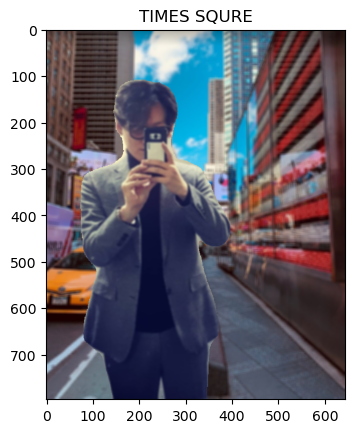

In [26]:
# --- 여기에 사람과 배경을 분리하여 합성하는 코드 추가 ---

# img_mask는 흑백 (0 또는 255)
# cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)를 사용하여 3채널 컬러 마스크로 변환 (기존 코드에서 이미 사용됨)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # 사람 255, 배경 0 (3채널)

# 1. 원본 이미지에서 사람 부분만 추출
# img_mask_color가 255인 곳(사람)은 img_orig 값을, 0인 곳(배경)은 0을 가지도록 함
img_person = np.where(img_mask_color == 255, img_orig, 0).astype(np.uint8)

# 2. 새로운 배경 이미지에서 배경 부분만 추출
# img_mask_color가 0인 곳(배경)은 img_new_bg_resized 값을, 255인 곳(사람)은 0을 가지도록 함
# 즉, 사람 마스크를 반전시켜 배경 마스크를 만듬
img_bg_mask = cv2.bitwise_not(img_mask_color) # 사람 0, 배경 255 (3채널)
img_background = np.where(img_bg_mask == 255, img_new_bg_resized, 0).astype(np.uint8)

# 3. 사람 부분과 배경 부분을 합성
# 두 이미지를 단순히 더하면 됩니다. (겹치는 부분이 없으므로)
img_final = img_person + img_background

# 최종 결과 시각화
print("--- 배경이 교체된 이미지 ---")
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.title("TIMES SQURE")
plt.show()

# --- 여기까지 추가 ---

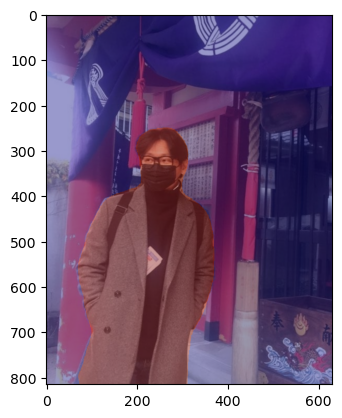

In [18]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.

img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

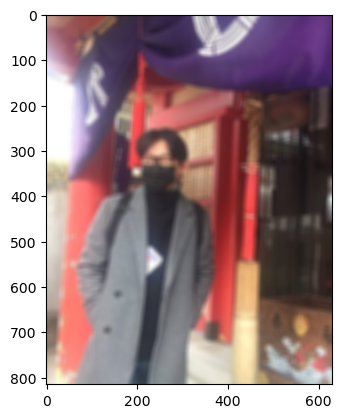

In [19]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13, 13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

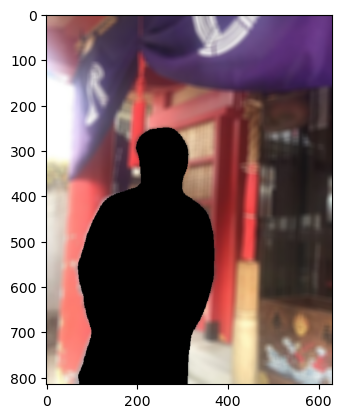

In [20]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

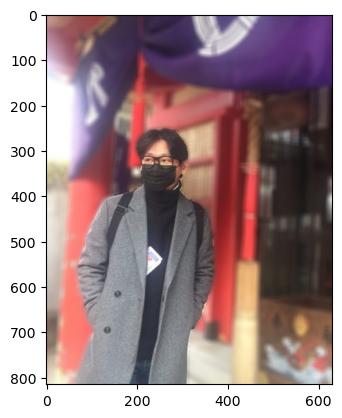

In [21]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

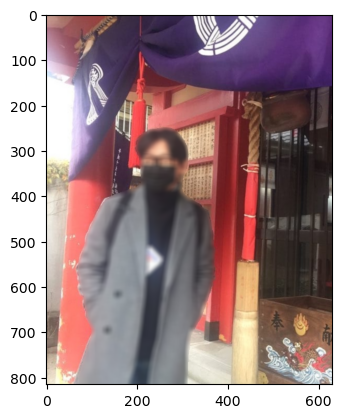

In [22]:
# Q. 이번에는 사람 부분을 블러로, 배경 부분을 원본으로 출력해볼까요?
# 힌트 : img_mask_color 옵션을 적절히 조정해주고, img_orig, img_orig_blur 를 활용하세요.
img_concat = np.where(img_mask_color == 255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()